In [65]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path


In [66]:
BASE_DIR = Path.cwd().parent
file_path = BASE_DIR / 'Datasets' / 'bitcoin_price.csv'

In [67]:
bitcoin_df = pd.read_csv(file_path,parse_dates=True, index_col='Date')
bitcoin_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [68]:
df = bitcoin_df[['Adj Close']].copy()
df.head()

,Adj Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [69]:
df.rename(columns = {'Adj Close' : 'y'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3392 entries, 2014-09-17 to 2023-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       3392 non-null   float64
dtypes: float64(1)
memory usage: 53.0 KB


In [70]:
df.index.freq = 'D'

In [71]:
df.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='Date', length=3392, freq='D')

### Closing price over years

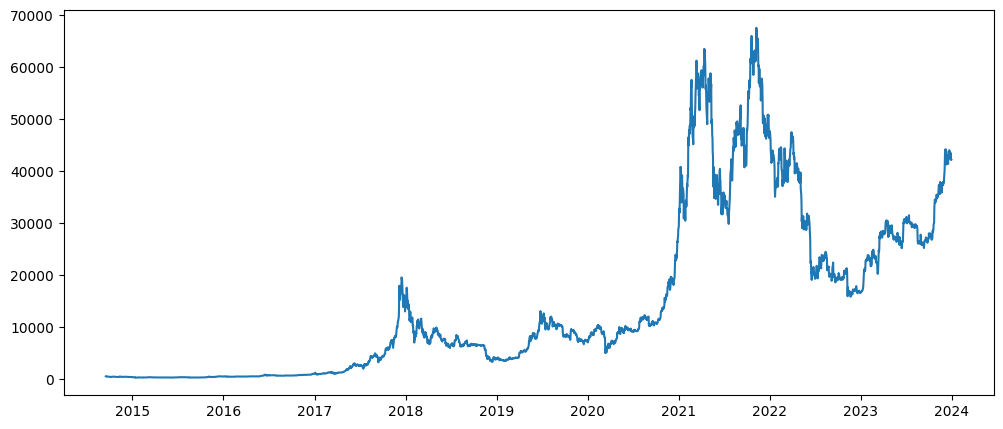

In [72]:
fig = plt.figure(figsize=(12,5))
plt.plot(df.index, df['y'])
plt.show()

### Seasonal Decomposition

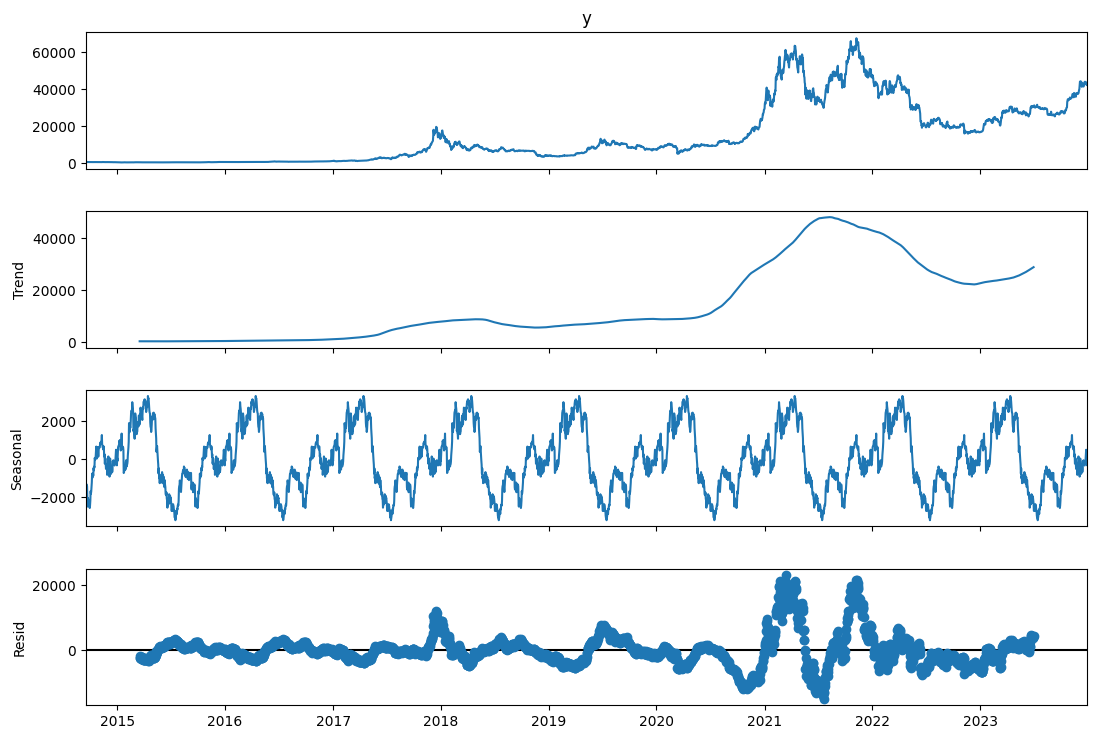

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df['y'],model='additive',period=365)
fig = decomposed.plot()
fig.set_size_inches(12,8)
plt.show()

### Seasonality plots

In [74]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

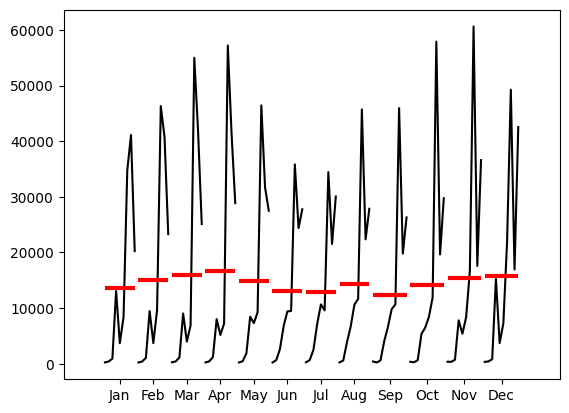

In [75]:
month_plot(df['y'].resample('ME').mean())
plt.show()

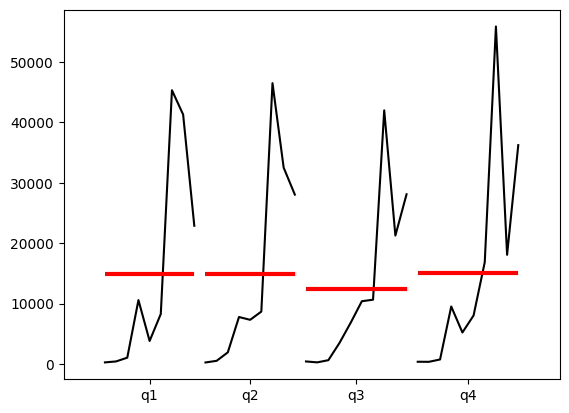

In [76]:
quarter_plot(df['y'].resample('QE').mean())
plt.show()

### Holt winter

In [77]:
periods = 365
train, test = df.iloc[:-periods], df.iloc[-periods:]
print(train.shape, test.shape)

(3027, 1) (365, 1)


In [89]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_es = ExponentialSmoothing(endog=train['y'],
                                trend = 'mul',
                                seasonal = 'mul',
                                seasonal_periods=7).fit()

test["forecast_es"] = model_es.forecast(periods)


C:\Users\shiva\AppData\Local\Temp\ipykernel_20028\3832442026.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["forecast_es"] = model_es.forecast(periods)


In [79]:
test.head()

,y,forecast_es
Date,,
2022-12-31,16547.496094,16227.449117
2023-01-01,16625.080078,16527.116290
2023-01-02,16688.470703,16731.519597
2023-01-03,16679.857422,16545.391437
2023-01-04,16863.238281,16322.023394


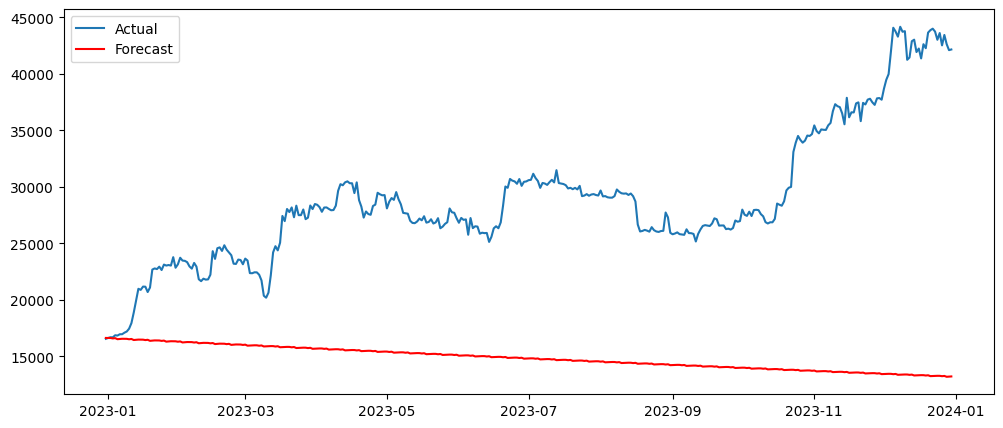

In [90]:
def plot_future(y,forecast):
    plt.figure(figsize=(12,5))
    plt.plot(y.index, y, label='Actual')
    plt.plot(forecast.index, forecast, label='Forecast', color='red')
    plt.legend()
    plt.show()

plot_future(test['y'], test['forecast_es'])

In [91]:
def evaulate_model(forecast,actual):
    mae = np.mean(np.abs(forecast - actual))
    mse = np.mean((forecast - actual)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((forecast - actual)/actual)) * 100
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')

evaulate_model(test['forecast_es'], test['y'])

#add trend and seasonality
# MAE: 22277.612938670438
# MSE: 601190299.7320735
# RMSE: 24519.182281064626
# MAPE: 73.582363811052

#add trend and mul seasonality
# MAE: 15325.422794252256
# MSE: 263660827.981098
# RMSE: 16237.636157430612
# MAPE: 51.56839359141245


MAE: 13939.879263072997
MSE: 239177273.03198764
RMSE: 15465.357190572342
MAPE: 45.75796635672328


### forecasting future

In [94]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_es = ExponentialSmoothing(endog=df['y'],
                                trend = 'mul',
                                seasonal = 'mul',
                                seasonal_periods=365).fit()

future_forecast = model_es.forecast(periods)

full_df = pd.concat([df,future_forecast.rename('forecast_es')],axis=1)


C:\Users\shiva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


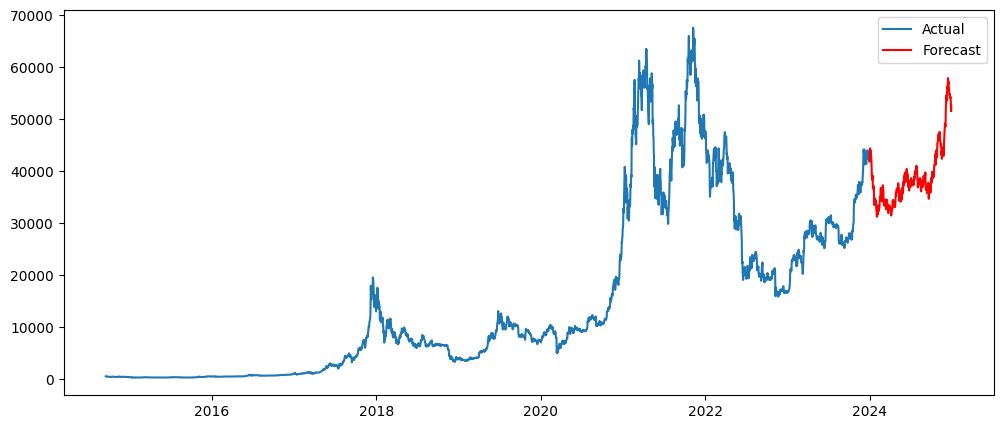

In [96]:
plot_future(full_df['y'], full_df['forecast_es'])
plt.show()